<font size=4>此檔案可快速導入我們以訓練好的 DipDECK，因此可以跳過耗時的訓練過程</font>

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
import torchvision
import torch.optim as optim

In [2]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = None
    def forward(self, inputs):
        outputs = self.encoder(inputs)
        return outputs
    
class Decoder(nn.Module):
    def __init__(self, d, m=5):
        super(Decoder, self).__init__()
        self.encoder = None
    def forward(self, inputs):
        outputs = self.encoder(inputs)
        return outputs

In [3]:
class DipDECK:
    def __init__(self, dataset, enc, dec, k_init=15, P_threshold=0.9, epochs=50, batch_size = 256):
        self.BATCHSIZE = None
        self.N_DATA, self.N_FEATURE = None, None
        self.data = None
        self.P_threshold = None
        self.k = None
        self.enc = None
        self.dec = None
        self.kmCentres = None
        self.labels = None
        self.centres = None
        self.DipMatrix, self.nDipMatrix = None, None

#### Load trained DipDECK model
儲存 model 的 .pkl 檔使用 protocol 5 封裝<br>
Use pickle5 (import pickle5 as pickle) or load it into python 3.8+

In [4]:
import pickle

with open('./saved_model/(new_k11) MNIST_kinit35_Pthreshold0.9_epoch50_024819_688495.pkl', 'rb') as inp:
    enc, dec = pickle.load(inp)  # pre-trained autoencoder
    Model = pickle.load(inp)

In [5]:
Model.__dict__

{'BATCHSIZE': 256,
 'N_DATA': 60000,
 'N_FEATURE': 784,
 'data': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'P_threshold': 0.9,
 'k': 11,
 'enc': Encoder(
   (encoder): Sequential(
     (0): Linear(in_features=784, out_features=500, bias=True)
     (1): ReLU()
     (2): Linear(in_features=500, out_features=500, bias=True)
     (3): ReLU()
     (4): Linear(in_features=500, out_features=2000, bias=True)
     (5): ReLU()
     (6): Linear(in_features=2000, out_features=5, bias=True)
   )
 ),
 'dec': Decoder(
   (encoder): Sequential(
     (0): Linear(in_features=5, out_features=2000, bias=True)
     (1): ReLU()
     (2): Linear(in_features=2000, out_features=500, bias=True)
     (3): ReLU()
     (4): Linear(in_features=500, out_features=500, bias=True)
     (5): ReLU()
     

#### Load train data

In [6]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms

import matplotlib.pyplot as plt

In [7]:
train_data = datasets.MNIST('./dataset',
                            train=True,
                            download=True,
                            transform=transforms.ToTensor())
train_data.data = train_data.data/255

#### confusion_matrix

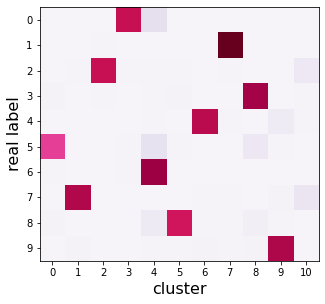

In [8]:
from sklearn.metrics import confusion_matrix, normalized_mutual_info_score

fig = plt.Figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('cluster', fontsize=16)
ax.set_ylabel('real label', fontsize=16)
confusionmatrix = confusion_matrix(train_data.targets, Model.labels)
ax.set_xticks(range(confusionmatrix.shape[1]))
ax.set_yticks(range(confusionmatrix.shape[0]))
ax.imshow(confusionmatrix[:-1], cmap='PuRd')
fig

#### rearranged confusion_matrix

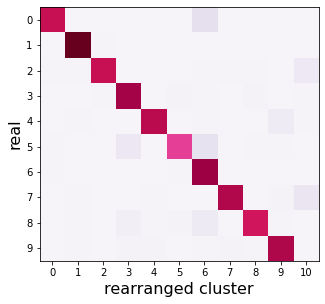

In [10]:
sorted_confusion_matrix = confusionmatrix[:,[3,7,2,8,6,0,4,1,5,9,10]]

fig = plt.Figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('rearranged cluster', fontsize=16)
ax.set_ylabel('real', fontsize=16)
ax.set_xticks(range(confusionmatrix.shape[1]))
ax.set_yticks(range(confusionmatrix.shape[0]))
ax.imshow(sorted_confusion_matrix[:-1], cmap='PuRd')
fig

#### NMI score

In [10]:
print(f'NMI={normalized_mutual_info_score(train_data.targets, Model.labels)}')

NMI=0.8322230164919371


#### Show the Origian, encoded and decoded train data

In [11]:
from ipywidgets import interact
import ipywidgets as widgets

label = 10

encoder = Model.enc.cpu()
decoder = Model.dec.cpu()

dat = train_data.data.view(-1,784)[Model.labels==label]
encoded_img = encoder(dat)
decoded_img = decoder(encoded_img)

encoded_img = encoded_img.detach().numpy()
decoded_img = decoded_img.detach().numpy()

def f(i):
    fig = plt.Figure(figsize=(10,10))
    ax1 = fig.add_subplot(1,3,1)
    ax2 = fig.add_subplot(1,3,2)
    ax3 = fig.add_subplot(1,3,3)
    ax1.axis('off')
    # ax2.axis('off')
    ax3.axis('off')
    ax1.imshow(dat[i].reshape(28,28), cmap='gray')
    ax2.imshow(encoded_img[i].reshape(1,5), cmap='gray')
    print(encoded_img[i].reshape(1,5))
    ax3.imshow(decoded_img[i].reshape(28,28), cmap='gray')
    return fig
    
interact(f, i=widgets.IntSlider(min=0, max=dat.shape[0]-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='i', max=1308), Output()), _dom_classes=('widget-interact…

<function __main__.f(i)>

In [15]:
def show_images(label, a=0):
    images = train_data.data.view(-1,784)[Model.labels==label][a:a+20]
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    for index, image in enumerate(images):
        plt.subplot(sqrtn, sqrtn, index+1)
        plt.imshow(image.reshape(28, 28), cmap='gray')
        plt.axis('off')

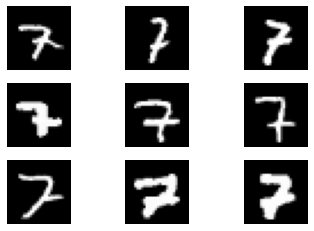

In [45]:
images = train_data.data.view(-1,784)[Model.labels==10][[12,20,23,46,87,159,196,225,549]]
sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
for index, image in enumerate(images):
    plt.subplot(sqrtn, sqrtn, index+1)
    plt.imshow(image.reshape(28, 28), cmap='gray')
    plt.axis('off')

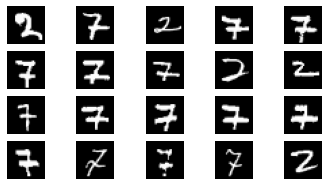

In [47]:
show_images(10, 580)

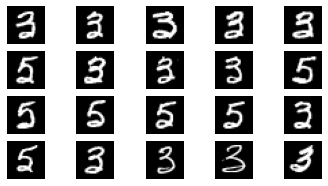

In [13]:
images = train_data.data.view(-1,784)[Model.labels==7][[2023,2024,2025,2026,2028,2029,2030,2031,2032,2033,2034,2037,2038,2039,2040,2041,2042,2075,2077,2106]]
sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
for index, image in enumerate(images):
    plt.subplot(sqrtn, sqrtn, index+1)
    plt.imshow(image.reshape(28, 28), cmap='gray')
    plt.axis('off')

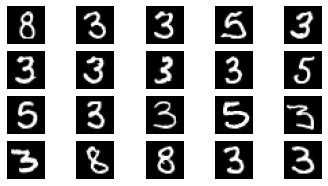

In [14]:
show_images(7, 2160)

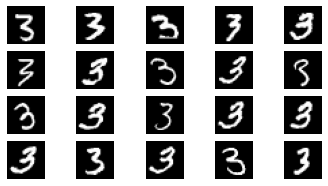

In [16]:
show_images(9, 275)